In [1]:
#importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [36]:
#initializing the parameters
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [3]:
#using tensor flow data input pipeline
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7354 files belonging to 5 classes.


In [4]:
#generating classs names
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Tomato_healthy']

In [5]:
#Visualizing the images
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 3 3 1 3 0 2 3 0 1 1 1 4 0 0 0 0 4 2 2 1 0 1 0 0 3 2 3 0 2 0 0]


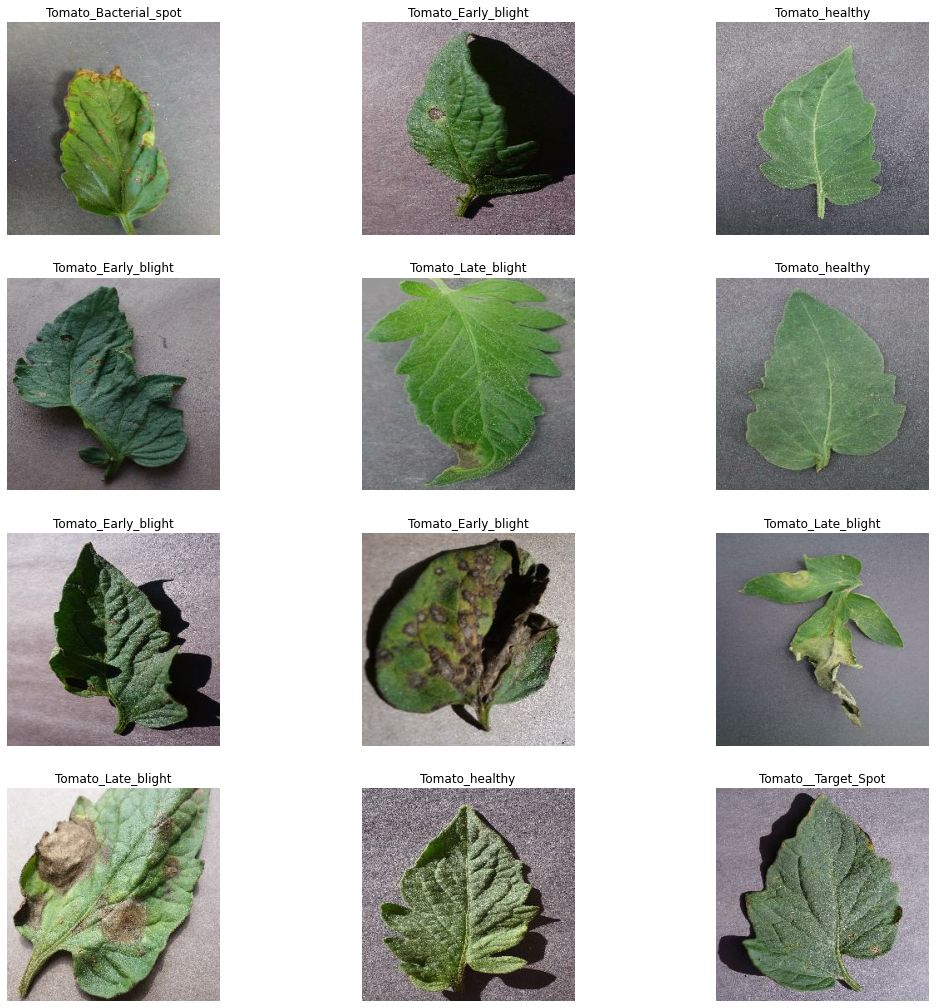

In [6]:
#plotting the images
plt.figure(figsize=(18, 18))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

230

In [8]:
#80% -> training
#20% -> 10% -> test, 10% -> validation
train_size = 0.8
len(dataset)*train_size

184.0

In [9]:
train_ds = dataset.take(184)
len(train_ds)

184

In [10]:
test_ds = dataset.skip(184)
len(test_ds)

46

In [11]:
val_size=0.1
len(dataset)*val_size

23.0

In [12]:
val_ds = test_ds.take(23)
len(val_ds)

23

In [13]:
test_ds = test_ds.skip(23)
len(test_ds)

23

In [14]:
#splitting dataset using a function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
#generating the values
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
#verifying the lengths
len(train_ds)

184

In [17]:
len(val_ds)

23

In [18]:
len(test_ds)

23

In [19]:
#applying caching to improve pipeline performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# resizing and scaling to get number between 0 and 1
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
#using data augmentation to make model robust
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
#building and training a CNN model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

#API
model.build(input_shape=input_shape)

#convolution layer
    #kernel size = size of filter
    #relu function = hidden activation layer, very famous, fast to compute
#pooling layer
    #max pooling = preserve features by reducing size of images

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
#compiling our model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
#keras call back history
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
184/184 [==============================] - 467s 2s/step - loss: 1.4276 - accuracy: 0.3803 - val_loss: 1.1405 - val_accuracy: 0.5489
Epoch 2/25
184/184 [==============================] - 852s 5s/step - loss: 0.8875 - accuracy: 0.6656 - val_loss: 1.1523 - val_accuracy: 0.5842
Epoch 3/25
184/184 [==============================] - 501s 3s/step - loss: 0.6221 - accuracy: 0.7652 - val_loss: 0.6457 - val_accuracy: 0.7568
Epoch 4/25
184/184 [==============================] - 459s 2s/step - loss: 0.4831 - accuracy: 0.8167 - val_loss: 0.7598 - val_accuracy: 0.7147
Epoch 5/25
184/184 [==============================] - 453s 2s/step - loss: 0.4260 - accuracy: 0.8402 - val_loss: 0.5648 - val_accuracy: 0.7826
Epoch 6/25
184/184 [==============================] - 442s 2s/step - loss: 0.4290 - accuracy: 0.8404 - val_loss: 0.7855 - val_accuracy: 0.7323
Epoch 7/25
184/184 [==============================] - 639s 3s/step - loss: 0.3809 - accuracy: 0.8596 - val_loss: 0.4066 - val_accuracy: 0.8438

In [27]:
#checking model on test model
scores = model.evaluate(test_ds)

23/23 [==============================] - 25s 532ms/step - loss: 0.1618 - accuracy: 0.9470


In [28]:
#parameters of history
history

In [29]:
#getting values sorted
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

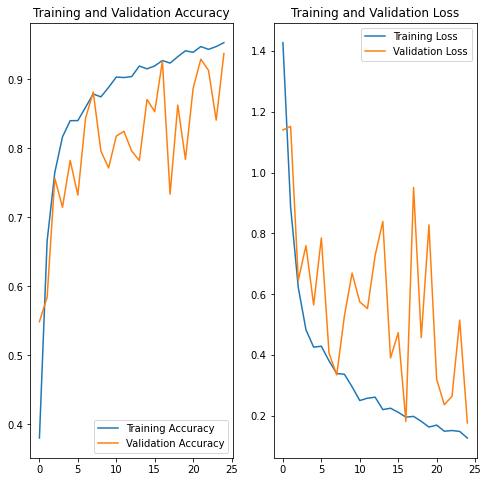

In [37]:
#plotting the params
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato__Target_Spot
1/1 [==============================] - 1s 830ms/step
predicted label: Tomato__Target_Spot


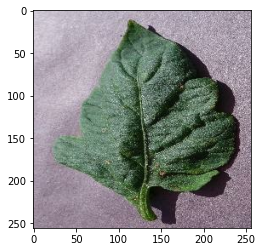

In [31]:
#making predictions/inference on sample images
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
#writing a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step


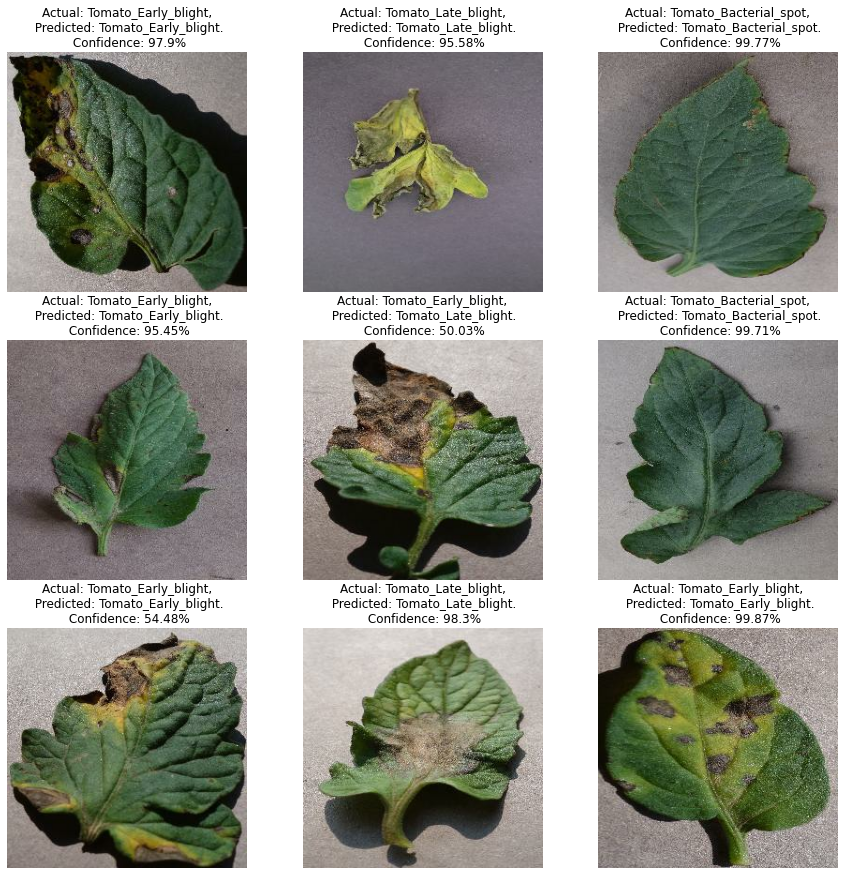

In [33]:
#now let us run inference on some sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [38]:
#saving the model
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [39]:
model.save("../tomato.h5")